# Classification

## 라이브러리 불러오기 및 경로설정

In [2]:
# Seed
import torch
import numpy as np
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize

from PIL import Image
import PIL

import os
from glob import glob
import cv2

from torch.optim import Adam
import pandas as pd
import torch.nn.functional as F

## Test Dataset 정의

In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [4]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

## Model 정의

In [5]:
class VGG11(nn.Module):
  def __init__(self, num_classes=1000):
    super(VGG11, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Classifier Part
    self.fc1      = nn.Linear(512 * 7 * 7, 4096)
    self.dropout1 = nn.Dropout()
    
    self.fc2      = nn.Linear(4096, 4096)
    self.dropout2 = nn.Dropout()
    
    self.fc3      = nn.Linear(4096, num_classes)
    

  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)
    x = self.pool5(x)

    # Fully Connected Classifier Part
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout2(x)
    
    x = self.fc3(x)
    return x

## Hyper-parameters 

In [6]:
data_root = '/opt/ml/input/data/train/images'
log_dir   = '/opt/ml/input/log'

batch_size = 32 # 8
lr = 1e-4
input_size = 224

## Dataset

In [7]:
class MaskDataset(Dataset):
  def __init__(self, data_root, is_Train=True, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list = self._load_img_list(data_root, is_Train)
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
    
    # Image Loading
    img = PIL.Image.open(img_path)

    if self.transform:
      img = self.transform(img)

    # Ground Truth
    label = self._get_class_idx_from_img_name(img_path)

    return img, label

  def __len__(self):
    return self.len

  def _load_img_list(self, data_root, is_Train): # 여기
    # Change the name of directory which has inconsistent naming rule.
    full_img_list = glob(data_root + '/*')
    for dir in full_img_list:
      dirname = os.path.basename(dir)
      if '-1' in dirname:
        os.rename(dir, dir.replace(dirname, dirname.replace('-1', '1')))
    
    # ID < 1000 for Training (N=721)
    # 1000 < ID < 1050 for Validation (N=63)  # 여기
    img_list = []
    for dir in glob(data_root + '/*'):
      if is_Train and (self._load_img_ID(dir) <= 5100): 
        img_list.extend(glob(dir+'/*'))
      elif not is_Train and (5100 < self._load_img_ID(dir) < 7960):
        img_list.extend(glob(dir+'/*'))

    return img_list

  def _load_img_ID(self, img_path):
    ret = os.path.basename(img_path).split('_')[0].split('-')[0]
    return int(ret)

  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path) 
    ret =int(img_name.split('_')[-1].split('.')[0])
    return ret

## Dataset and Data Loader

In [8]:
transform = transforms.Compose(
    [transforms.Resize((244, 244)),
     transforms.CenterCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])


train_dataset = MaskDataset(data_root, is_Train=True, input_size=input_size, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

valid_dataset = MaskDataset(data_root, is_Train=False, input_size=input_size, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

In [9]:
# Misc

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## fine tuning

In [10]:
from torchvision.models import vgg11

pretrained = True # True of False

model = vgg11(pretrained)
model.classifier[6] = nn.Linear(in_features=4096, out_features=18, bias=True) # 여기
model.cuda()

# Freeze the feature extracting convolution layers
for param in model.features.parameters():
    param.requires_grad = False

## Loss function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

## Main

In [13]:
# Main
os.makedirs(log_dir, exist_ok=True)
PATH = '/opt/ml/model/vgg/vgg11_model.pth'

with open(os.path.join(log_dir, 'fine_tuned_train_log.csv'), 'w') as log:
  # Training
  for iter, (img, label) in enumerate(train_loader):
        
    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer.zero_grad()

    # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
    img, label = img.to(device='cuda').float(), label.to(device='cuda')

    # 모델에 이미지 forward
    pred_logit = model(img)

    # loss 값 계산
    loss = criterion(pred_logit, label)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    pred_label = pred_logit.argmax(1)
    acc = torch.div((pred_label == label).sum(), float(label.shape[0]))

    train_loss = loss.item()
    train_acc = acc

    # Validation for every 20 epoch
    if (iter % 20 == 0) or (iter == len(train_loader)-1):
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in valid_loader:
        # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
        img, label = img.to(device='cuda').float(), label.to(device='cuda')

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
            pred_logit = model(img)

        # loss 값 계산
        loss = criterion(pred_logit, label)

        # Accuracy 계산
        pred_label = pred_logit.argmax(1)
        acc = torch.div((pred_label == label).sum(), float(label.shape[0]))

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(train_loader), train_loss, train_acc, valid_loss, valid_acc))
      
      torch.save(model.state_dict(), PATH)
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/435] | Train Loss 2.8068 | Train Acc 0.1562 | Valid Loss 2.5915 | Valid Acc 0.2065
Iter [ 20/435] | Train Loss 1.5887 | Train Acc 0.5000 | Valid Loss 1.8667 | Valid Acc 0.3493
Iter [ 40/435] | Train Loss 1.6403 | Train Acc 0.5000 | Valid Loss 1.6364 | Valid Acc 0.4288
Iter [ 60/435] | Train Loss 1.3099 | Train Acc 0.6250 | Valid Loss 1.4968 | Valid Acc 0.4899
Iter [ 80/435] | Train Loss 0.9964 | Train Acc 0.5938 | Valid Loss 1.4497 | Valid Acc 0.5302
Iter [100/435] | Train Loss 1.3688 | Train Acc 0.6250 | Valid Loss 1.3485 | Valid Acc 0.5344
Iter [120/435] | Train Loss 0.6574 | Train Acc 0.7188 | Valid Loss 1.2779 | Valid Acc 0.5826
Iter [140/435] | Train Loss 0.6156 | Train Acc 0.7500 | Valid Loss 1.1040 | Valid Acc 0.6361
Iter [160/435] | Train Loss 0.6234 | Train Acc 0.7812 | Valid Loss 1.1799 | Valid Acc 0.6270
Iter [180/435] | Train Loss 0.7002 | Train Acc 0.7500 | Valid Loss 1.2146 | Valid Acc 0.6046
Iter [200/435] | Train Loss 0.4196 | Train Acc 0.8750 | Valid Loss 1.1

## Training Log Visualization

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Load log file
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

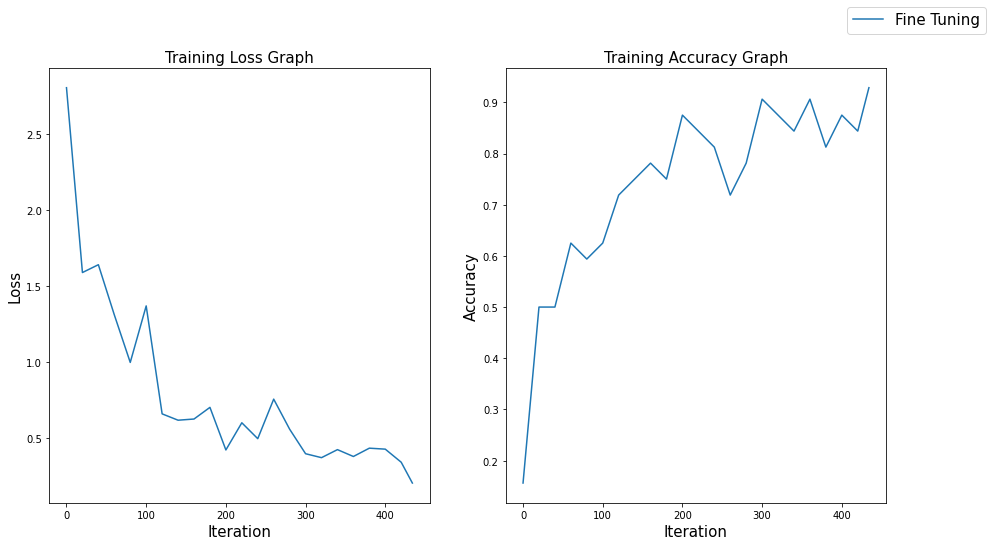

In [16]:
# Visualize training log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

# ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

# ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()

## Inference

In [35]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model_ = vgg11()
model_.classifier[6] = nn.Linear(in_features=4096, out_features=18, bias=True) # 여기
model_.cuda()
model_.load_state_dict(torch.load(PATH))
model_.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model_(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
